# 0.0 - IMPORTS

In [78]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib as plt

from IPython.core.display import HTML

## 0.1 Helper Functions

## 0.2 Loading Data

In [24]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how ='left', on ='Store' )

In [25]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
412372,608,5,2014-06-27,9775,988,1,0,0,0,a,c,18370.0,2.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
981173,759,6,2013-02-02,4608,570,1,0,0,0,a,a,110.0,11.0,2012.0,1,31.0,2013.0,"Feb,May,Aug,Nov"


# 1.0 - DESCRIÇÃO DOS DADOS

## Data fields
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
Note that all schools are closed on public holidays and weekends.
a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating,
1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew

E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [26]:
df1 = df_raw.copy() #copio o DataFrame para esse bloco

## 1.1 Rename Columns

In [27]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [28]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
               'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list(map(snakecase, old_columns))

#rename
df1.columns = new_columns

In [29]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [30]:
#Qual a qtd de linhas e colunas do dataset
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [31]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [32]:
#A coluna date era object e vamos mudá-la para formato de data
df1['date'] = pd.to_datetime(df1['date'])

In [33]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [34]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

### Os NA precisam ser tratados.
#### 1) Jogar essas linhas fora -> VTG: rápido e fácil | DVG: jogar dado fora, pode prejudicar a performance do modelo
#### 2) Usando métodos de ML para substituir as linhas NA pelo comportamento da coluna (mediana, média, previsões)
#### 3) Entendendo o negócio. Pq esse NA está aqui?

#### Vamos tratar pelo método 3 cada coluna com NA. 
#### competition_distance
#### competition_open_since_month    
#### competition_open_since_year
#### promo2_since_week               
#### promo2_since_year               
#### promo_interval                  

In [36]:
#------------------------------------------------------------------------------------
#competition_distance
#------------------------------------------------------------------------------------
#se tem NA é porque não tem competidor próximo (assumption) => usar o método isnan da classe math
#esse método vai me dizer se nesa linha da coluna competition_distance o valor é NA.
#vamos substituir o valor onde for NA por um valor muito grande!!!

#encontrando o valor máximo de competition_distance 75860.0
#df1['competition_distance'].max()

#Logo vamos admitir um valor bem alto 200000.0 para as linhas com valor NA, substituindo df1 por x
#para aplicar essa função em todas as linhas, usar o método apply
#Terei que especificar em qual coluna será aplicada a função, posso retirar do interior o ['competition_distance']
#O resultado dessa função quero sobreescrever os resultados originais
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

In [46]:
#------------------------------------------------------------------------------------
#competition_open_since_month & competition_open_since_year
#------------------------------------------------------------------------------------
#se tem NA é porque ou não tem competidor ou esqueceram de lançar o mês de que ele chegou
#colocar o mês da venda como mês do competidor (assumption) => usar o método isnan da classe math
#primeiro ver se ela é NA, com o método isnan, e fazer uma condição
#se isso for vdd vou extrair o mês da coluna date e colocar nela
#se não for vdd eu retorno o valor (depois do else)
#chamando a função lambda eu posso substituir o df1
#axis=1 pois tenho mais de uma coluna e preciso explicitar que a ação será em cada linha ao longo das colunas
#quero que o resultado sobreescreva a coluna original competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


#mesmo raciocício para competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


#mesmo raciocício para promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#mesmo raciocício para promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)




In [40]:
#------------------------------------------------------------------------------------
#promo_interval
#------------------------------------------------------------------------------------
#Criar uma coluna auxiliar para 
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                             else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                             else 0, axis = 1)


In [47]:
df1.sample(5).T

,748211,355040,777461,747035,917568
store,832,1016,1092,771,709
day_of_week,5,3,7,6,7
date,2013-08-30 00:00:00,2014-08-27 00:00:00,2013-08-04 00:00:00,2013-08-31 00:00:00,2013-03-31 00:00:00
sales,7298,3989,0,4649,0
customers,651,426,0,472,0
open,1,1,0,1,0
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,a,a,a


## 1.6 Check Types

In [48]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [49]:
#ajustar os tipos competition de float para int
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [51]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [75]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [53]:
#Qual a qtd de linhas e colunas do dataset
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 20


## 1.7 Statistical Descriptive

In [ ]:
#Entender o negócio
#Conseguir detectar erros -> Métricas de dispersão (desvio padrão, variância, mín, máx, range, skew e kurtosis)
#e de tendência central (médias e medianas)
#skew: como que a deformação da minha distribuição em relação a normal
#kurtose: fala sobre a concentração dos dados

In [56]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [62]:
#Central Tendency (mean, median)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion (std, min, max, var, skew, kurtosis)
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


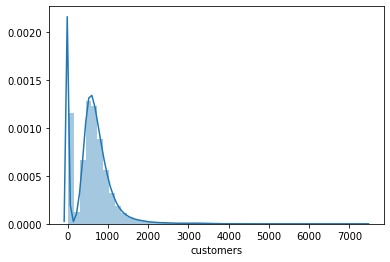

In [67]:
sns.distplot(df1['customers'])

### 1.7.2 Categorical Attributes

In [69]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

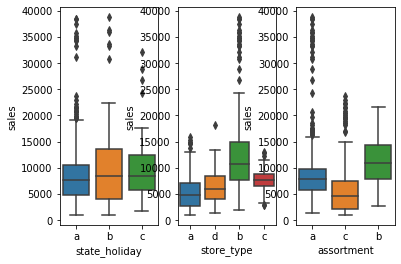

In [87]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.pyplot.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1 )

plt.pyplot.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' , data=aux1 )

plt.pyplot.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' , data=aux1 )

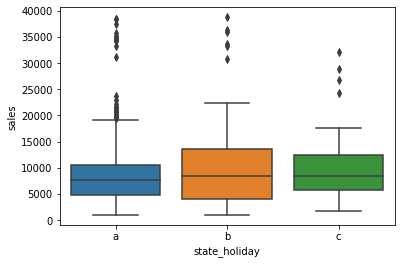

In [88]:
sns.boxplot(x='state_holiday' , y='sales' , data=aux1 )

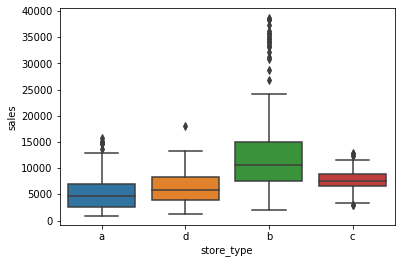

In [89]:
sns.boxplot(x='store_type' , y='sales' , data=aux1 )

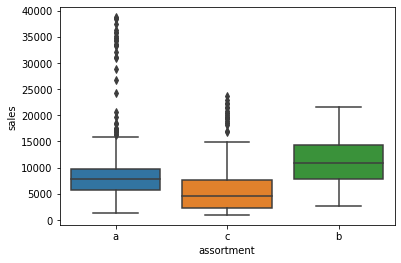

In [90]:
sns.boxplot(x='assortment' , y='sales' , data=aux1 )

## 1.8